# Лабораторная работа №1
## Выполнили Смирнов Егор и Максимов Артем 

В этой лабораторной мы реализовали 3 алгоритма поиска подстроки в строке:
    
- Наивный алгоритм
- Алгоритм Boyer-Moure_Horspool
- Алгоритм Rabin-Karp
    
и сравнили скорость их работы(через количество атомарных итераций)

In [1]:
#imports
import random
import matplotlib.pyplot as plt
from math import log10

## Функции для тестировки

In [2]:
def string_generator(alp_length, str_length):
    string = []
    for i in range(str_length):
        string.append(chr(ord('a') + random.randint(0, alp_length - 1)))
    return ''.join(string)

def testset_generator(alp_length, str_length):
    testset = []
    for i in range (1000):
        testset.append(string_generator(alp_length, str_length))
    return testset

def iterations_computation(algorithm, pattern, alp_length, testset):
    max_count = avg_count = sum_count = 0
    min_count = 1e6
    for string in testset:
        result = algorithm(string, pattern, alp_length)
        count = result[1]
        sum_count += count
        if count >= max_count:
            max_count = count
        if count <= min_count:
            min_count = count
    avg_count = sum_count / len(testset)
    return max_count, min_count, avg_count

def test_on_naive(string, pattern, shifts_alg):
    result = []
    shifts_naive, counts = Naive(string,pattern)
    if shifts_alg != shifts_naive:
        print("Error")
        print(shifts_alg)
        print(shifts_naive)
        print(string, pattern)
        print("---------------------------")

Сгенеровали паттерн длины 5 и 4 сета тестовых данных длин 10, 100, 1000 и 10000 элементов

Количество букв в алфавите - 4

## Реализация наивного алгоритма

За атомарные итерации считали количество сдвигов и сравнений

In [3]:
def Naive(string, pattern, alp_length):
    shifts_list = []
    shifts_count = comparisons_count = 0
    for i in range(len(string) - len(pattern) + 1):
        if i > 0:
            shifts_count += 1
        j = 0
        while(j < len(pattern)):
            comparisons_count += 1
            if string[i + j] != pattern[j]:
                break
            j += 1
        if j == len(pattern):
            shifts_list.append(i)
    return shifts_list, shifts_count + comparisons_count

## Реализация алгоритма Boyer-Moure-Horspool

За атомарные операции считали действия, совершенные во время препроцессинга, сдвиги и  операции сравнения символов

In [4]:
def preprocessing_BMH(pattern, alp_length):
    shifts_table = [len(pattern) for i in range(alp_length)]
    preprocessing_count = alp_length

    for i in range(len(pattern) - 1):
        preprocessing_count += 1
        shifts_table[ord(pattern[i]) - 97] = len(pattern) - 1 - i
    return shifts_table, preprocessing_count

In [5]:
def BMH(string, pattern, alp_length):
    table, preprocessing_count = preprocessing_BMH(pattern, alp_length)
    shifts = []
    shift_count = comparison_count = 0
    i = 0
    while (i < len(string) - len(pattern) + 1):
        shift_count += 1
        flag = True
        j = len(pattern) - 1
        while (j >= 0):
            comparison_count += 1
            if pattern[j] != string[i + j]:
                i += table[ord(string[i + len(pattern) - 1]) - ord('a')] - 1
                flag = False
                break
            j -= 1     
        if flag:
            shifts.append(i)
        i += 1
    #test_on_naive(string, pattern, shifts)
    return shifts, shift_count + comparison_count + preprocessing_count

Результат работы сравнивается с результатом, выданным наивным алгоритмом для проверки правильнотси работы

## Реализация алгоритма Rabin-Karp

За атомарные операции считали сдвиги, сравненние символов, хэширование и сравнение хэшей

In [6]:
class RKhasher:
    q = 2305843009213693951
    x = 2305893951

    @staticmethod
    def hash(string, len_pattern):
        res = 0
        for i in range(len_pattern):
            res += ord(string[i]) * RKhasher.x**(len_pattern - 1 - i)
        return res % RKhasher.q

    @staticmethod
    def move(hs, len_pattern, string, i):
        return ((hs - ord(string[i]) * RKhasher.x**(len_pattern - 1))*RKhasher.x + ord(string[(i + len_pattern) % len(string)])) % RKhasher.q

In [7]:
def RabinKarp(string, pattern, alp_length):
    shifts = []
    shift_count = len(string)
    comparison_count = len(string) - len(pattern) # ну или 0, количество сравнений хешей примерно равно количеству сдвигов
    hs = RKhasher.hash(string, len(pattern))
    hpat = RKhasher.hash(pattern, len(pattern))
    for i in range(len(string) - len(pattern) + 1):
        if hs == hpat:
            j = 0
            while j < len(pattern):
                comparison_count += 1
                if string[i+j] != pattern[j]:
                    break
                j += 1
            if j == len(pattern):
                shifts.append(i)
        hs = RKhasher.move(hs, len(pattern), string, i)
    #test_on_naive(string, pattern, shifts)
    return shifts, shift_count + comparison_count

После мы визуализировали полученные результаты:

In [8]:
def graph_result(pattern_len, alp_lens):
    alg_list = [Naive, BMH, RabinKarp]
    x = [10**x for x in range(1,5)]
    for alp_length in alp_lens:
        sets = [0] * 4
        pattern = string_generator(alp_length, pattern_len)
        for i in map(lambda x : 10**x, range(1, 5)):
                sets[int(log10(i)) - 1] = testset_generator(alp_length, i)
        for algo in alg_list:
            y = []
            for i in range(4):
                y.append(iterations_computation(algo, pattern, alp_length, sets[i])[2])
            plt.plot(x, y)
            plt.yticks(y)
            plt.xscale('log')
        plt.show()

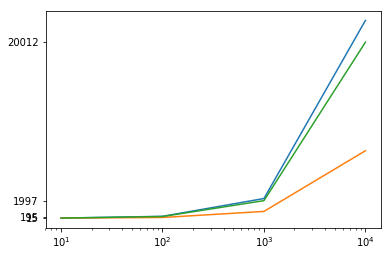

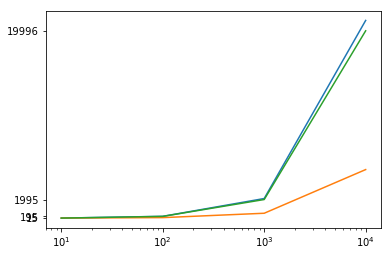

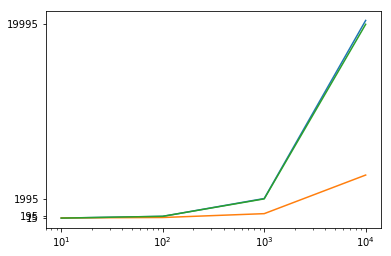

In [9]:
pattern_len = 5
alp_lens = [5, 10, 26]

graph_result(pattern_len, alp_lens) #Посмотрим на влияние мощности алфавита

В общем, можно заметить, что количество итераций относительно длины строки зависит линейно: длина строки увеличилась в 10 раз - количество операций увеличилось примерно также.

Самые плохие результаты показывает наивный алгоритм, самые хорошие - алгоритм BMH, что не удивительно, ведь последний лучше всего оптимизирует количество сдвигов за счет эвристики "плохого символа".

По какой-то причине на алфавите бОльшего размеры алгоритмы дают более хорошие результаты.